In [96]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import linregress, pearsonr
import pandas as pd
from collections import defaultdict

np.random.seed(42)

## Task0

#### Ex. 1

In [71]:
# https://snap.stanford.edu/data/

file_path = "input/facebook_combined.txt"

G = nx.Graph()

with open(file_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        u, v = parts
        u, v = int(u), int(v)
        G.add_edge(u, v)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("First 5 edges with weights:")
for u, v, data in list(G.edges(data=True))[:5]:
    print(u, v)

Number of nodes: 4039
Number of edges: 88234
First 5 edges with weights:
0 1
0 2
0 3
0 4
0 5


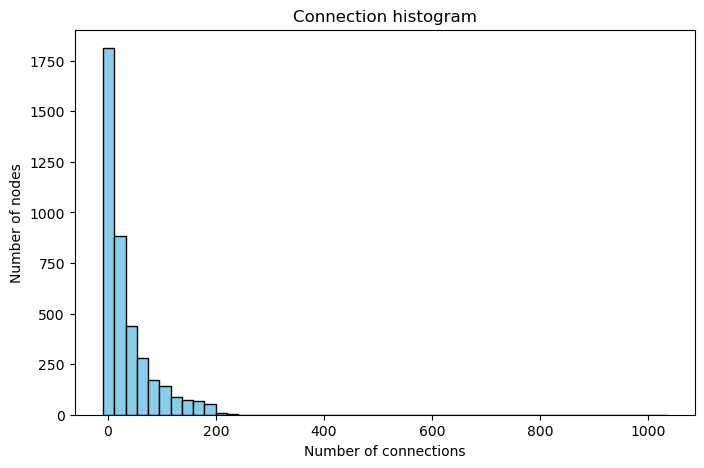

In [4]:
# drawing histogram
degrees = [val for (node, val) in G.degree()]

plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=50, color="skyblue", edgecolor="black", align="left")
plt.xlabel("Number of connections")
plt.ylabel("Number of nodes")
plt.title("Connection histogram")
plt.show()

#### Ex. 2

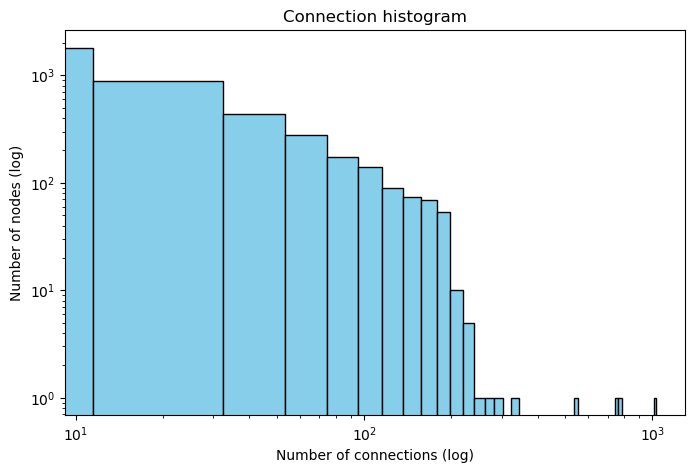

In [37]:
# drawing histogram on double log scale
degrees = [val for (node, val) in G.degree()]

plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=50, color="skyblue", edgecolor="black", align="left")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of connections (log)")
plt.ylabel("Number of nodes (log)")
plt.title("Connection histogram")
plt.show()

#### Ex. 3

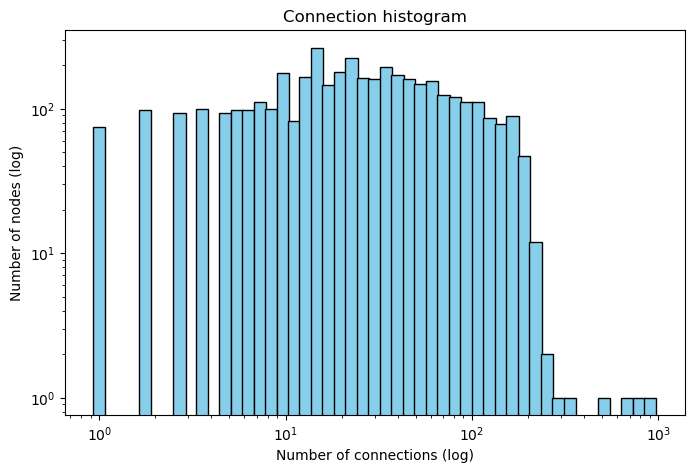

In [6]:
# applying log binning
degrees = [val for (node, val) in G.degree()]
degrees = np.array(degrees)
degrees = degrees[degrees > 0]
bins = np.logspace(np.log10(degrees.min()), np.log10(degrees.max()), 50)

plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=bins, color="skyblue", edgecolor="black", align="left")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of connections (log)")
plt.ylabel("Number of nodes (log)")
plt.title("Connection histogram")
plt.show()

# moreless uniform-like

#### Ex. 4

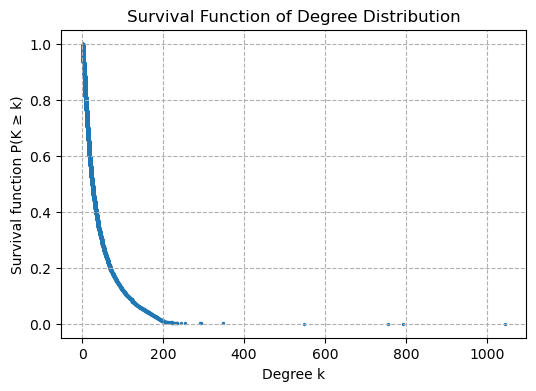

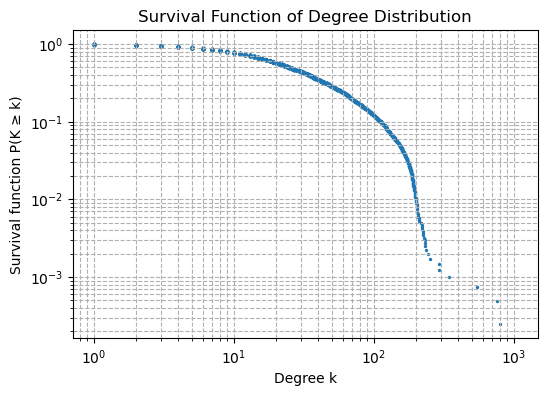

In [26]:
# survival function S(x) = 1 - F(x)

degrees = [val for (node, val) in G.degree()]

sorted_degrees = np.sort(degrees)
survival = 1.0 - np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)

plt.figure(figsize=(6, 4))
plt.scatter(sorted_degrees, survival, marker='o', s=2)
plt.xlabel("Degree k")
plt.ylabel("Survival function P(K ≥ k)")
plt.title("Survival Function of Degree Distribution")
plt.grid(True, which="both", ls="--")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(sorted_degrees, survival, marker='o', s=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree k")
plt.ylabel("Survival function P(K ≥ k)")
plt.title("Survival Function of Degree Distribution")
plt.grid(True, which="both", ls="--")
plt.show()

#### Ex. 5

In [28]:
# log-binned histogram (probably best, all the range of values at different scales is visible) and survival function are the most readable

#### Ex. 6

Estimated alpha: 2.140
R² = 0.852


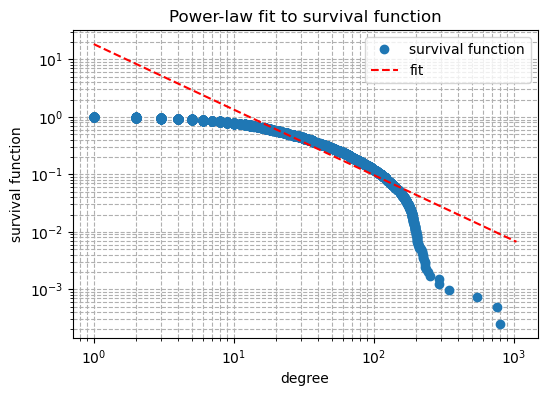

In [74]:
# determining alpha using linear regression

degrees = np.array([d for n, d in G.degree()])
sorted_degrees = np.sort(degrees)
survival = 1.0 - np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)

k_min = 10
mask = (sorted_degrees > k_min) & (survival > 0)
x = np.log10(sorted_degrees[mask])
y = np.log10(survival[mask])

slope, intercept, r_value, p_value, std_err = linregress(x, y)

alpha_est = 1 - slope  # slope = -(α - 1) for the CCDF
print(f"Estimated alpha: {alpha_est:.3f}")
print(f"R² = {r_value**2:.3f}")

# Plot with the regression line
plt.figure(figsize=(6,4))
plt.loglog(sorted_degrees, survival, 'o', label='survival function')
plt.loglog(sorted_degrees, 10**(intercept + slope * np.log10(sorted_degrees)), 'r--', label='fit')
plt.xlabel("degree")
plt.ylabel("survival function")
plt.title("Power-law fit to survival function")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Task 3

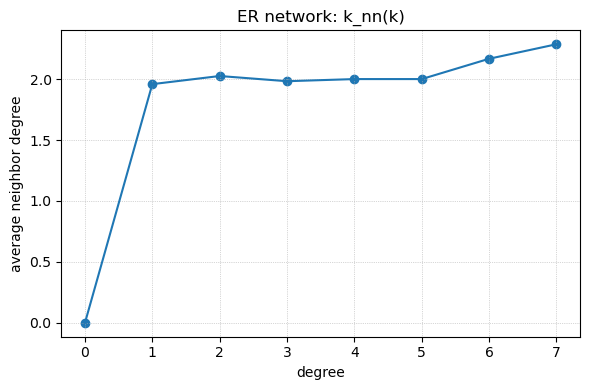

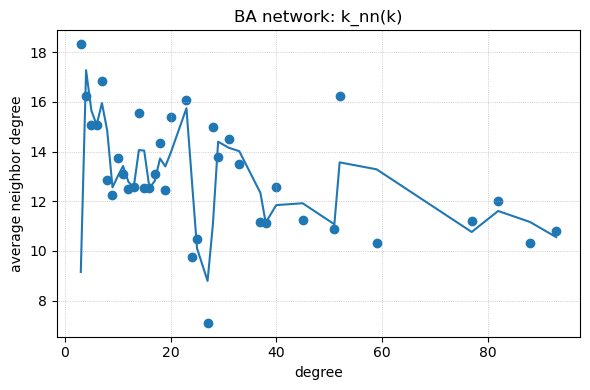

In [84]:
def compute_k_nn_by_k(G):
    and_vals = nx.average_neighbor_degree(G)
    deg = dict(G.degree())
    agg = defaultdict(list)
    for node, k in deg.items():
        agg[k].append(and_vals[node])
    rows = []
    for k in sorted(agg):
        vals = np.array(agg[k])
        rows.append((k, vals.mean(), vals.std(ddof=0), len(vals)))
    df = pd.DataFrame(rows, columns=['k','k_nn_mean','k_nn_std','count'])
    return df

n = 1000
p_er = 0.001
m_ba = 3 

G_er = nx.erdos_renyi_graph(n, p_er, seed=42)
G_ba = nx.barabasi_albert_graph(n, m_ba, seed=42)

df_er = compute_k_nn_by_k(G_er)
df_ba = compute_k_nn_by_k(G_ba)

def plot_knn(df, title):
    plt.figure(figsize=(6,4))
    plt.scatter(df['k'], df['k_nn_mean'])
    ks = df['k'].values
    knn = df['k_nn_mean'].values
    window = max(1, int(len(ks)*0.06))
    smooth = np.convolve(knn, np.ones(window)/window, mode='same')
    plt.plot(ks, smooth)
    plt.xlabel('degree')
    plt.ylabel('average neighbor degree')
    plt.title(title)
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_knn(df_er, "ER network: k_nn(k)")
plot_knn(df_ba, "BA network: k_nn(k)")

## Task 4

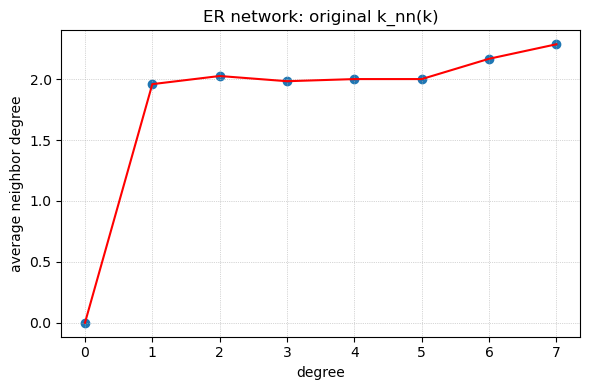

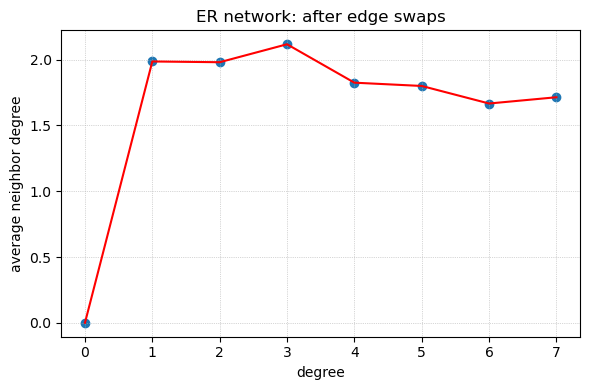

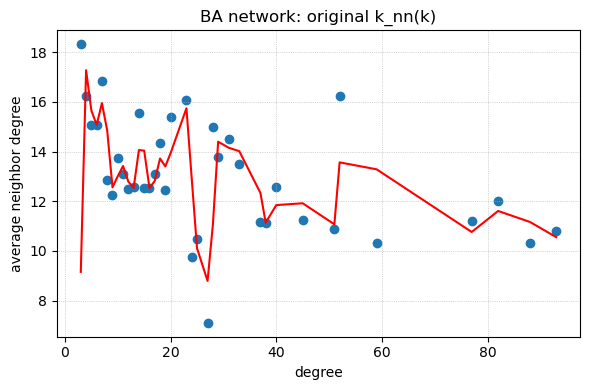

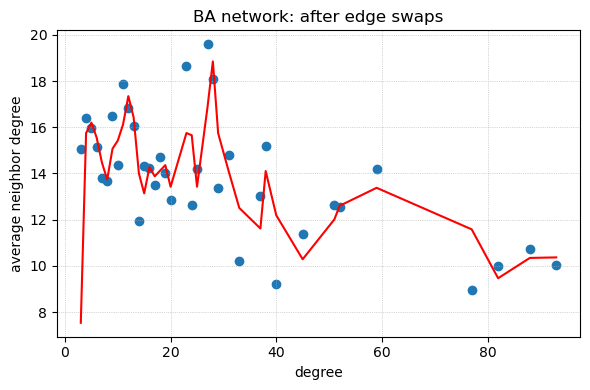

In [100]:
n = 1000
p_er = 0.001
m_ba = 3 
num_swaps = 10000

G_er = nx.erdos_renyi_graph(n, p_er, seed=42)
G_ba = nx.barabasi_albert_graph(n, m_ba, seed=42)

df_er = compute_k_nn_by_k(G_er)
df_ba = compute_k_nn_by_k(G_ba)

G_er_swapped = G_er.copy()
nx.double_edge_swap(G_er_swapped, nswap=num_swaps, max_tries=num_swaps*10)

G_ba_swapped = G_ba.copy()
nx.double_edge_swap(G_ba_swapped, nswap=num_swaps, max_tries=num_swaps*10)

df_er_swapped = compute_k_nn_by_k(G_er_swapped)
df_ba_swapped = compute_k_nn_by_k(G_ba_swapped)

plot_knn(df_er, "ER network: original k_nn(k)")
plot_knn(df_er_swapped, "ER network: after edge swaps")
plot_knn(df_ba, "BA network: original k_nn(k)")
plot_knn(df_ba_swapped, "BA network: after edge swaps")

# the results are similar

## Task 6

In [101]:
# correlation coef

def correlation_knn(G):
    deg = np.array([d for n, d in G.degree()])
    knn = np.array([nx.average_neighbor_degree(G)[n] for n in G.nodes()])
    r, _ = pearsonr(deg, knn)
    return r

r_er = correlation_knn(G_er)
r_er_swapped = correlation_knn(G_er_swapped)
r_ba = correlation_knn(G_ba)
r_ba_swapped = correlation_knn(G_ba_swapped)

print(f"ER network correlation: original={r_er:.3f}, swapped={r_er_swapped:.3f}")
print(f"BA network correlation: original={r_ba:.3f}, swapped={r_ba_swapped:.3f}")

ER network correlation: original=0.628, swapped=0.610
BA network correlation: original=-0.112, swapped=-0.043
